## MTS using Keras LSTM

In [ ]:
import numpy as np

from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
dataset = read_csv("Data_Chevron.csv", index_col=0)
# load dataset
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]

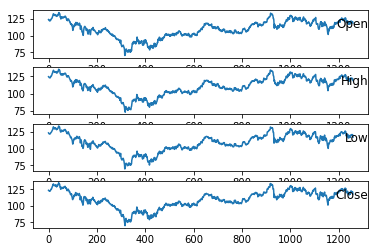

In [5]:
i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [6]:
values = dataset[['Open', 'High', 'Low']].values

In [7]:
close_values = dataset['Close'].values

In [8]:
close_values = close_values.reshape(-1,1)

In [9]:
close_values.shape

(1259, 1)

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled_close = close_scaler.fit_transform(close_values)

In [11]:
complete_scaled = np.concatenate((scaled, scaled_close), axis=1)

In [12]:
complete_scaled.shape

(1259, 4)

In [13]:
reframed = series_to_supervised(complete_scaled, 20, 1)

In [14]:
reframed.shape

(1239, 84)

In [15]:
reframed.drop(reframed.columns[[80,81,82]], axis=1, inplace=True)

In [16]:
reframed.shape

(1239, 81)

In [17]:
values = reframed.values
train = values[:800, :]
test = values[800:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(800, 1, 80) (800,) (439, 1, 80) (439,)


In [18]:
model = Sequential()
model.add(LSTM(128, return_sequences = False, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               107008    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 107,137
Trainable params: 107,137
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(
    train_X, 
    train_y, 
    epochs=50, 
    batch_size=72, 
    validation_split=0.2,
    #validation_data=(test_X, test_y), 
    verbose=0, shuffle=False)

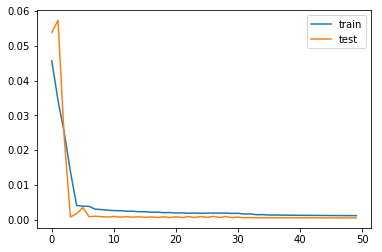

In [21]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig("loss-rmse.jpg", dpi=200)
pyplot.show()

In [22]:
# make a prediction
yhat = model.predict(test_X)
test_X_final = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = close_scaler.inverse_transform(yhat)


In [23]:
# invert scaling for actual
test_y_final = test_y.reshape((len(test_y), 1))
inv_y = close_scaler.inverse_transform(test_y_final)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.290


In [24]:
print("MAPE: %.3f" % mean_absolute_percentage_error(inv_y, inv_yhat))

MAPE: 1.441


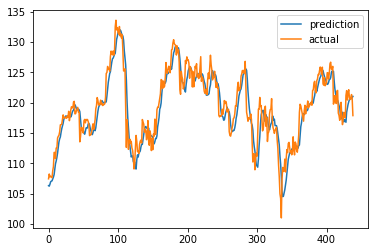

In [25]:
pyplot.plot(inv_yhat, label = 'prediction')
pyplot.plot(inv_y, label = 'actual')
pyplot.legend()
pyplot.savefig("pred vs act.jpg", dpi=200)
pyplot.show()